# ADAPTER - cross validation 2x2

### Variables to set prior to run

In [2]:
import os
import wandb

suffix = "2x2"

Transformers = "/home/lieberze/DP/Thesis/05_model_training/"
TransformerName = os.path.abspath(os.path.join(Transformers, "roberta-trained-new-tokenizer_params_4")) 

TokenizerPath = "/home/lieberze/DP/Thesis/02_tokenizery_new_data/02_ByteLevelBPE/All_genomes_sample/All_512/5000/"

# where to save trained adapters
SaveToFolder = f"{suffix}_CV"

NumberOfEpochs = 4
TrainBatchSize = EvalBatchSize = 16
LearningRate = 3e-4
WarmupRatio = 0.08 # 8 %
AdamEpsilon = 1e-08
WeightDecay = 0.0005

num_GPU = 3

### Imports

In [3]:
import torch
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from keras.preprocessing.sequence import pad_sequences
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from transformers import RobertaTokenizer
from transformers import AdapterTrainer, AutoModelWithHeads
from transformers.training_args import TrainingArguments

from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import EvalPrediction
from sklearn import metrics

RANDOM_STATE = 42

### Paths and setting labels

In [4]:
RootFolder = "/home/lieberze/DP/Thesis/"
Baseline = os.path.abspath(os.path.join(RootFolder, "04_baseline"))
Adapter = os.path.abspath(os.path.join(RootFolder, "06_adapter"))
DataFolder = os.path.abspath(os.path.join(Baseline, "data"))
TestFolder = os.path.abspath(os.path.join(DataFolder, "test"))
TrainFolder = os.path.abspath(os.path.join(DataFolder, "train"))

# train and test file paths
if suffix == "3x3":
    TrainFile = os.path.abspath(os.path.join(TrainFolder, "Train_250k.txt"))
    TestFile = os.path.abspath(os.path.join(TestFolder, "Test_holdout_100k.txt"))
elif suffix == "2x2":
    TrainFile = os.path.abspath(os.path.join(TrainFolder, "2x2_train_200k.txt"))
    TestFile = os.path.abspath(os.path.join(TestFolder, "2x2_test_100k.txt"))
    
# labels to categorise
if suffix == "3x3":
    CATEGORIES = ['exon', 'intergenic','intron']
elif suffix == "2x2":
    CATEGORIES = ['exon', 'other']
    
id2label = {id:label for id, label in enumerate(CATEGORIES)}
label2id = {label:id for id,label in id2label.items()}
id2label, label2id
    
# enable GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained(TokenizerPath)
tokenizer.vocab_size

file /home/lieberze/DP/Thesis/02_tokenizery_new_data/02_ByteLevelBPE/All_genomes_sample/All_512/5000/config.json not found


5000

### Dataset class

In [5]:
# defining the Dataset class
class data_set(Dataset):
    def __init__(self, data, labels, tokenizer):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        seq = self.data[index]
        lab = self.labels[index]
        lab_id = label2id[lab]
        tokenized = tokenizer(seq, max_length=128, padding="max_length", truncation=True)   
        tokenized_with_label = tokenized
        tokenized_with_label["labels"] = lab_id
        return tokenized_with_label

### Load data

In [6]:
df_TRAIN = pd.read_csv(TrainFile, sep="\t", names=['type','sequence'])
df_HOLDOUT = pd.read_csv(TestFile, sep="\t", names=['type','sequence'])

if suffix == "2x2":
    subs = {
            "exon": "exon", 
            "intron": "other",
            "intergenic": "other"
            }
    df_TRAIN["type"] = [subs.get(item) for item in df_TRAIN["type"]]
    df_HOLDOUT["type"] = [subs.get(item) for item in df_HOLDOUT["type"]]
    
# dataset for train is created in k-folds in the next cell
dataset_holdout = data_set(df_HOLDOUT["sequence"], df_HOLDOUT["type"], tokenizer)

In [7]:
len(df_TRAIN), len(df_HOLDOUT)

(200000, 200000)

In [8]:
# NumberOfEpochs = 1
# df_TRAIN = df_TRAIN[:1000]

### Run kfold CV

In [9]:
kfold = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
split_generator = kfold.split(df_TRAIN)

In [ ]:
for i, result in enumerate(split_generator):   
    wandb.init(project = f"adapter_CV_{suffix}")
    
    # create datasets for k-fold
    train, validation = df_TRAIN.iloc[result[0]], df_TRAIN.iloc[result[1]]
    train = train.reset_index()
    validation = validation.reset_index()    
    data_set_train = data_set(train["sequence"],train["type"], tokenizer)
    data_set_eval = data_set(validation["sequence"],validation["type"], tokenizer)
    
    # initialise model and adapter instance
    AdapterName = f"{suffix}_fold_{i}"
    model = AutoModelWithHeads.from_pretrained(TransformerName)
    model.add_adapter(AdapterName)
    model.add_classification_head(AdapterName, num_labels=len(CATEGORIES), id2label = id2label) #, multilabel=False)
    model.train_adapter(AdapterName) # inicializace

    # calculate eval_steps_to_set and some info to print
    WANTED_eval_data_points_ratio = 0.1 # 10% of all optimization steps is going to have an evaluation datapoint (loss)
    total_optimization_steps = round(len(train)/TrainBatchSize/num_GPU)*NumberOfEpochs
    eval_steps_in_one_run = round(len(validation)/(NumberOfEpochs*TrainBatchSize)/num_GPU) 
    eval_steps_to_set=int(round(total_optimization_steps*WANTED_eval_data_points_ratio, 0))
    print("total_optimization_steps:",total_optimization_steps,
          "\nhow many 'eval_steps' to set:",eval_steps_to_set,
          "\nhow many steps in each evaluation stop:",eval_steps_in_one_run,
          "\nhence in total:", eval_steps_to_set*eval_steps_in_one_run, "steps for the whole evaluation" )

    training_args =  TrainingArguments(
        learning_rate=LearningRate,
        num_train_epochs=NumberOfEpochs,
        report_to="wandb",
        output_dir = SaveToFolder,
        label_names = CATEGORIES,
        eval_steps = eval_steps_to_set, 
        evaluation_strategy="steps",
        per_device_train_batch_size=TrainBatchSize,
        per_device_eval_batch_size=EvalBatchSize,
        do_eval=True,
        logging_steps=100, 
        warmup_ratio = WarmupRatio,
        adam_epsilon=AdamEpsilon,
        weight_decay=WeightDecay,
        save_steps=10_000,
        save_total_limit=2,
         # The next line is important to ensure the dataset labels are properly passed to the model
        remove_unused_columns=False,
        seed=1,
    )
    
    ## problem: compute_metrics doesn't get called by the adapter training
    # https://discuss.huggingface.co/t/trainer-never-invokes-compute-metrics/11440/4
    def compute_metrics(p: EvalPrediction):
        logits, labels = p
        preds = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, preds)
        f1_weighted = f1_score(labels, preds, average='weighted')
        
        report = metrics.classification_report(labels, preds, digits=2, output_dict=True, zero_division=0)
        df_report = pd.DataFrame(report).transpose()
        return {"acc": acc, "f1_weighted": f1_weighted, "report":df_report}

    model.metrics=['f1_weighted']

    trainer = AdapterTrainer(
            model=model,
            args=training_args,
            train_dataset=data_set_train,
            eval_dataset=data_set_eval,
            compute_metrics = compute_metrics,
        )

    # first train model, save results
    result = trainer.train()
    
    # evaluation metrics, manually, because (for unknown reason) the model itself doesn't return them
    y_pr = data_set_eval.labels
    y_pr = [label2id[i] for i in y_pr]
    loss = trainer.compute_metrics([trainer.predict(data_set_eval).predictions[1], y_pr])
    Metrics = trainer.evaluate()
    
    print(loss, Metrics)
    !mkdir -p $Adapter/$SaveToFolder/$AdapterName
    
    # saving results
    with open(f"{Adapter}/{SaveToFolder}/{AdapterName}/metrics_{suffix}.pkl", "wb") as f:
        pickle.dump({"loss":loss, "metrics":Metrics, "result":result}, f)

    # saving adapter
    trainer.save_model(SaveToFolder) # folder into which we save (the name is in the trainer)
    wandb.finish()

## Pak nějak pohrotit ty výsledky cross validace:

In [ ]:
label2id

Example for one fold:

In [ ]:
# AdapterName = f"{suffix}_fold_9"
# with open(f"{SaveToFolder}/{AdapterName}/metrics_{suffix}.pkl", "rb") as f:
#     x = pickle.load(f)
#     print(x)

# x["loss"]
# x["metrics"]
# x["result"]

tabulka pro celý cv train

In [10]:
round_to = 3
rslts = []
for i in range(10):   
    AdapterName = f"{suffix}_fold_{i}"
    with open(f"{SaveToFolder}/{AdapterName}/metrics_{suffix}.pkl", "rb") as f:
        x = pickle.load(f)
        acc = x["loss"]["acc"]
        f1_w = x["loss"]["f1_weighted"]
        pcsn_w = x["loss"]["report"]["precision"]["weighted avg"]
        recall_w = x["loss"]["report"]["recall"]["weighted avg"]
        rslts.append({"accuracy":acc, "f1_weighted":f1_w, "precision_weighted":pcsn_w, "recall_weighted":recall_w})
        
df_results = {}
for i, name in enumerate(["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"]):
    v = []
    for j, values in enumerate(rslts):
        v.append(values[name])
    mean = round(np.mean(v), round_to)
    std = round(np.std(v), round_to)
    df_results[name] = f"{mean} \u00B1 {std}"
dataframe = pd.DataFrame.from_dict(df_results,orient='index').T
display(dataframe)

,accuracy,precision_weighted,recall_weighted,f1_weighted
0,0.783 ± 0.003,0.789 ± 0.003,0.783 ± 0.003,0.782 ± 0.003


In [14]:
f1_weighted_for_f_test = [i["f1_weighted"] for i in rslts]
f1_weighted_for_f_test

[0.7791448895934493,
 0.777942756193739,
 0.78332571374095,
 0.7845702752514406,
 0.7856723891087809,
 0.7794784934099609,
 0.779420100636675,
 0.7861543853430892,
 0.7820121773837995,
 0.7808982587762405]

## Load adapter, test on holdout:

In [10]:
# from transformers import TextClassificationPipeline
# model = AutoModelWithHeads.from_pretrained(TransformerName)
# tokenizer = tokenizer

# adapter1 = model.load_adapter(f"{SaveToFolder}/{suffix}_fold_9")
# model.active_adapters = adapter1

# classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=training_args.device.index)

# sequences = list(df_HOLDOUT.sequence)
true_labels = list(df_HOLDOUT.type)
# pred_labels = classifier(sequences)

# pred_lab = [i["label"] for i in pred_labels]
# pred_score = [i["score"] for i in pred_labels]

# print(pred_labels[:30])

# import pickle
# with open(f"{SaveToFolder}/pred_labels_fold_9_{suffix}.pk", 'wb') as f:
#     pickle.dump(pred_labels, f)

tady je videt, ze jakmile je to exon, tak si je hodne jistej => nejspis se uci podle delky :/

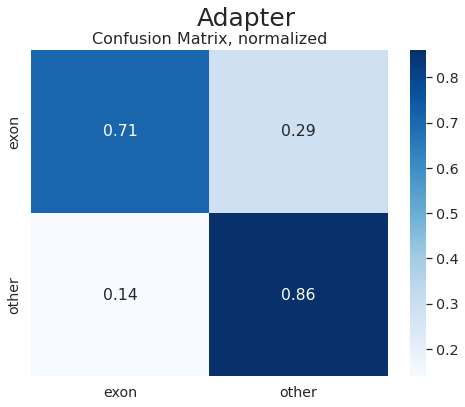

              precision   recall  f1-score       support
exon           0.835664  0.70998  0.767712  100000.00000
other          0.747896  0.86038  0.800205  100000.00000
accuracy       0.785180  0.78518  0.785180       0.78518
macro avg      0.791780  0.78518  0.783958  200000.00000
weighted avg   0.791780  0.78518  0.783958  200000.00000


In [11]:
import sys 
sys.path.insert(0, "./../" )
from my_classes import ClassificationMetrics

# create and save conf matrix
TitleName = "Adapter"
CMName = f"{Adapter}/{SaveToFolder}/confusion_matrix_{suffix}.png"
ClassificationMetrics.ConfMatrix(true_labels, pred_lab, CATEGORIES, TitleName, CMName)

report = metrics.classification_report(true_labels, pred_lab, digits=2, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report).transpose()
df_report.to_pickle(f"{Adapter}/{SaveToFolder}/report_{suffix}.pkl")
df_report.to_excel(f"{Adapter}/{SaveToFolder}/report_holdout_{suffix}.xlsx") 
print(df_report)

In [12]:
# true_labels, pred_lab
import pickle
with open(f"{SaveToFolder}/pred_labels_fold_9_{suffix}.pk", 'rb') as f:
    pred_labels = pickle.load(f)

In [ ]:
# pred_labels

In [13]:
pred_lab = [i["label"] for i in pred_labels]
pred_score = [i["score"] for i in pred_labels]

In [14]:
pred_score = [i["score"] if i["label"]=="exon" else 1-i["score"] for i in pred_labels]
pred_score[:10]

[0.00795668363571167,
 0.3890717625617981,
 0.48611778020858765,
 0.18679237365722656,
 0.9966337084770203,
 0.15421390533447266,
 0.09063196182250977,
 0.9741445183753967,
 0.003233671188354492,
 0.419979453086853]

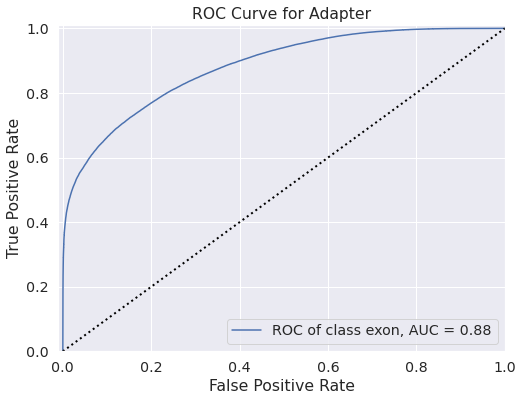

In [21]:
title = "exon"
my_title = f"ROC Curve for Adapter"
plt.figure(figsize=[8,6])
sns.set(font_scale=1.3)       
# y = np.array(y_test)
y = true_labels
# pred = model.predict_proba(X_test)[:,1]
pred = pred_score
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label="exon")
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                               estimator_name=my_title)
# display.plot()
plt.title(my_title)
auc = round(np.trapz(tpr,fpr),2)
plt.plot(fpr,tpr,label="ROC of class exon, AUC = "+str(auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='dotted')
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([-0.01,1.0])
plt.ylim([0.00,1.01])
plt.savefig(f'{Adapter}/{SaveToFolder}/ROC_curve_{suffix}.png')
plt.show() 